In [1]:
import pyemma as pm
import deeptime as dt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import *

In [2]:
raw_ts = pd.read_hdf('1fme/raw.h5', key='timescales')
raw_vs = pd.read_hdf('1fme/raw.h5', key='vamps')

df = pd.merge(raw_ts, raw_vs, left_index=True, right_index=True)
df.columns=['ts', 'vamp']
df.reset_index(inplace=True)
df  = df.loc[(df.hp_ix.isin([24, 235])) & (df.lag==41) & (df.process==2), :]
df_m = df.melt(value_vars=['ts', 'vamp'],id_vars=['hp_ix'])

# The problem

Two models appear to have vamp scores in reverse order to their implied dominant timescale.Below shows the median values of the VAMP2(k=2) score with the slowest timescale.  Under that are the respective distributions. These tables and charts clearly show the problem. 

In [3]:
df.groupby(['hp_ix']).median()

,bs_ix,lag,process,ts,vamp
hp_ix,,,,,
24,49.0,41.0,2.0,20500.491982,1.976101
235,49.5,41.0,2.0,8025.668786,1.980394


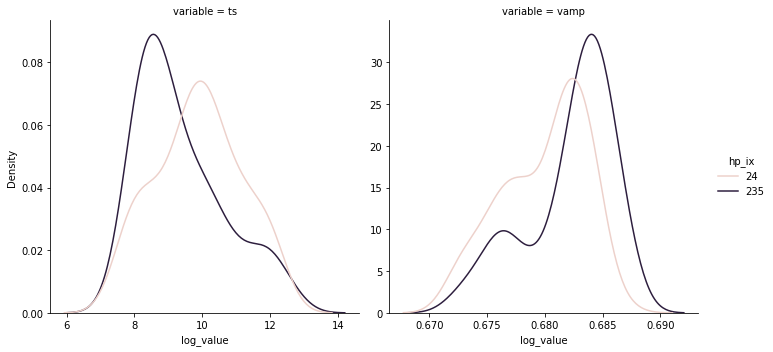

In [4]:
df_m['log_value'] = np.log(df_m['value'])
g = sns.displot(data=df_m, x ='log_value',  hue='hp_ix', col='variable', kind='kde', facet_kws={'sharex': False, 'sharey':False})

Does this pattern hold up for each bootstrap iteration? The chart below shows that the gradient of the timescales with respect to the vamp scores is equal parts positive and negative.  Very strange. 

/home/rob/miniconda3/envs/msmsense/lib/python3.8/site-packages/seaborn/distributions.py:2352: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


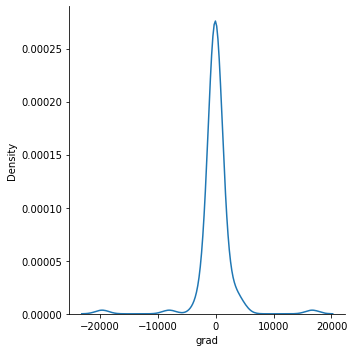

In [5]:
df_w = df.pivot(values=['ts', 'vamp'], columns=['hp_ix'], index='bs_ix')
df_w['grad'] = (np.log(df_w.loc[:, ('ts', 235)]) - np.log(df_w.loc[:, ('ts', 24)]))/(df_w.loc[:, ('vamp', 235)] - df_w.loc[:, ('vamp', 24)])
sns.displot(df_w, x='grad', kind='kde')

# Specific models

So let's investigate the problem in a detailed manner. We can't easily access the bootstrapped dtrajs, so we'll just have to use all the data and hope we can find an error. 

In [6]:
root_dir = '/home/rob/Research/msm_sensitivity_analysis/data/msms/1fme'

dtrajs_by_ix = {235: [np.load(x) for x in Path(root_dir).joinpath('dtrajs', f'hp_235').glob('1FME-*npy')], 
                24: [np.load(x) for x in Path(root_dir).joinpath('dtrajs', f'hp_24').glob('1FME-*npy')]} 

mods_by_ix = {k: pm.msm.estimate_markov_model(v, lag=41, reversible=True) for k, v in dtrajs_by_ix.items()}

In [7]:
mods_by_ix[24].timescales(1), mods_by_ix[235].timescales(1)

(array([3346.15812548]), array([2865.45687631]))

In [8]:
mods_by_ix[24].score(dtrajs_by_ix[24], score_k=2), mods_by_ix[235].score(dtrajs_by_ix[235],score_k=2)

(1.97594101742623, 1.9723373805833049)

So this doesn't show the problem - but we should check the calcualtions anyway. 

VAMP1 - this should equal the sum of the eigenvalues

In [9]:
{k: np.log10(np.abs(v.eigenvalues()[:2].sum() - v.score(dtrajs_by_ix[k], score_method='vamp1', score_k=2))) for k, v in mods_by_ix.items()}

{235: -3.5556784074592014, 24: -4.122813182694715}

VAMP2 - this should equal the sum of the squared eigenvalues: 

In [11]:
{k: np.log10(np.abs((v.eigenvalues()[:2]**2).sum() - v.score(dtrajs_by_ix[k], score_method='vamp2', score_k=2))) for k, v in mods_by_ix.items()}bootstrapping

SyntaxError: invalid syntax (1284898946.py, line 1)

This error only gets bigger with more eigenvectors being score (here with 10): 

In [12]:
{k: np.log10(np.abs((v.eigenvalues()[:10]**2).sum() - v.score(dtrajs_by_ix[k], score_method='vamp2', score_k=10))) for k, v in mods_by_ix.items()}

{235: -2.844878359657049, 24: -2.1923279305774277}

# Scoring

In [13]:
from deeptime.decomposition import vamp_score
??vamp_score

Signature:
vamp_score(
    koopman_model,
    r: Union[float, str],
    covariances_test=None,
    dim: Union[int, NoneType] = None,
    epsilon: float = 1e-10,
)
Source:   
def vamp_score(koopman_model, r: Union[float, str],
               covariances_test=None, dim: Optional[int] = None, epsilon: float = 1e-10):
    """Compute the VAMP score between a covariance-based Koopman model and potentially a
    test model for cross-validation.

    Parameters
    ----------
    koopman_model : deeptime.decomposition.CovarianceKoopmanModel
        The model to score.
    r : float or str
        The type of score to evaluate. Can by an floating point value greater or equal to 1 or 'E', yielding the
        VAMP-r score or the VAMP-E score, respectively. :footcite:`wu2020variational`
        Typical choices (also accepted as inputs) are:

        *  'VAMP1'  Sum of singular values of the half-weighted Koopman matrix.
                    If the model is reversible, this is equal to the sum of
 

In [22]:
from deeptime.numeric import is_sorted, spd_inv_sqrt, schatten_norm



def vamp(dtrajs: List[np.ndarray], lag: int, dim: int, epsilon: float = 1e-6) -> float: 
    
    # Get the covariance koopman model
    est = dt.markov.msm.MaximumLikelihoodMSM(reversible=True, lagtime=lag)
    est.fit(dtrajs)
    mod = est.fetch_model()
    koopman_model = mod.empirical_koopman_model
    
    # Get test covariances
    cov_test = koopman_model.cov
    
    # sort the indices according to singular values
    if not is_sorted(koopman_model.singular_values, 'desc'):
        sort_ix = np.argsort(koopman_model.singular_values)[::-1][:dim]  # indices to sort in descending order
    else:
        sort_ix = np.arange(koopman_model.singular_values.shape[0])[:dim]  # already sorted    
        
    U = koopman_model.instantaneous_coefficients[:, sort_ix]
    V = koopman_model.timelagged_coefficients[:, sort_ix]
    
    A = np.atleast_2d(spd_inv_sqrt(U.T.dot(cov_test.cov_00).dot(U), epsilon=epsilon))
    B = np.atleast_2d(U.T.dot(cov_test.cov_0t).dot(V))
    C = np.atleast_2d(spd_inv_sqrt(V.T.dot(cov_test.cov_tt).dot(V), epsilon=epsilon))
    ABC = np.linalg.multi_dot([A, B, C])
    vamp1 = schatten_norm(ABC, 1) ** 1
    vamp2 = schatten_norm(ABC, 2) ** 2
    
    
    K = np.diag(koopman_model.singular_values[sort_ix])
        # see https://arxiv.org/pdf/1707.04659.pdf eqn. (30)
    vampe = np.trace(2.0 * np.linalg.multi_dot([K, U.T, cov_test.cov_0t, V])
                     - np.linalg.multi_dot([K, U.T, cov_test.cov_00, U, K, V.T, cov_test.cov_tt, V]))
    
    with np.printoptions(precision=10):
        print('A: ')
        print(np.round(A, 10))
        print('B: ')
        print(np.round(B, 10))
        print('C: ')
        print(np.round(C, 10))
        print('Lambdas   =', mod.eigenvalues(2))
        print('Lambdas^2 =', mod.eigenvalues(2)**2)

        print('Sum lambdas =   ', np.round(mod.eigenvalues(2).sum(), 4))
        print('VAMP1 =         ', np.round(vamp1, 4))
        print('Sum lambdas^2 = ', np.round((mod.eigenvalues(2)**2).sum(), 4))
        print('VAMP2 =         ', np.round(vamp2, 4))              
        print('VAMPE =         ', np.round(vampe, 4))
        print(f't_2 =            {np.round(mod.timescales(1)[0], 0)}')
    print('-'*80)

In [23]:
vamp(dtrajs_by_ix[24], lag=41, dim=2, epsilon=1e-6)
vamp(dtrajs_by_ix[235], lag=41, dim=2, epsilon=1e-6)

A: 
[[1. 0.]
 [0. 1.]]
B: 
[[ 1.000000000e+00 -1.600000000e-09]
 [ 0.000000000e+00  9.878972707e-01]]
C: 
[[1. 0.]
 [0. 1.]]
Lambdas   = [1.           0.9878219027]
Lambdas^2 = [1.           0.9757921114]
Sum lambdas =    1.9878
VAMP1 =          1.9879
Sum lambdas^2 =  1.9758
VAMP2 =          1.9759
VAMPE =          1.9759
t_2 =            3346.0
--------------------------------------------------------------------------------
A: 
[[1. 0.]
 [0. 1.]]
B: 
[[ 1.000000000e+00 -1.700000000e-09]
 [-0.000000000e+00  9.860716914e-01]]
C: 
[[1. 0.]
 [0. 1.]]
Lambdas   = [1.           0.9857935141]
Lambdas^2 = [1.           0.9717888525]
Sum lambdas =    1.9858
VAMP1 =          1.9861
Sum lambdas^2 =  1.9718
VAMP2 =          1.9723
VAMPE =          1.9723
t_2 =            2865.0
--------------------------------------------------------------------------------


let's try proper bootstrapping

In [17]:
bs_dtraj_by_ix = dict()
bs_dtraj_by_ix[24] = [np.load(x) for x in Path('../tests/dtrajs/hp_24/bs_0').glob('dtraj*.npy')]
bs_dtraj_by_ix[235] = [np.load(x) for x in Path('../tests/dtrajs/hp_235/bs_0').glob('dtraj*.npy')]

In [18]:
print(np.allclose(np.load('../tests/dtrajs/hp_24/bs_0/bs_ix.npy'), np.load('../tests/dtrajs/hp_235/bs_0/bs_ix.npy')))
bs_ix = np.load('../tests/dtrajs/hp_24/bs_0/bs_ix.npy')

True


In [19]:
vamp(bs_dtraj_by_ix[24], lag=41, dim=2, epsilon=1e-6)
vamp(bs_dtraj_by_ix[235], lag=41, dim=2, epsilon=1e-6)

A: 
[[1. 0.]
 [0. 1.]]
B: 
[[1.     0.    ]
 [0.     0.9823]]
C: 
[[1. 0.]
 [0. 1.]]
Lambdas   = [1.     0.9983]
Lambdas^2 = [1.     0.9966]
Sum lambdas =    1.9983
VAMP1 =          1.9823
Sum lambdas^2 =  1.9966
VAMP2 =          1.9649
VAMPE =          1.9649
t_2 =            23940.0
--------------------------------------------------------------------------------
A: 
[[1. 0.]
 [0. 1.]]
B: 
[[ 1.     -0.    ]
 [ 0.      0.9901]]
C: 
[[ 1. -0.]
 [-0.  1.]]
Lambdas   = [1.     0.9843]
Lambdas^2 = [1.     0.9688]
Sum lambdas =    1.9843
VAMP1 =          1.9901
Sum lambdas^2 =  1.9688
VAMP2 =          1.9804
VAMPE =          1.9804
t_2 =            2585.0
--------------------------------------------------------------------------------
